# Step 1: Data Loading and Preprocessing
We'll start by loading the data and handling any preprocessing tasks such as dealing with missing values and normalizing text fields.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, f1_score
from imblearn.over_sampling import SMOTE
import gensim

In [2]:
# # Load the datasets
try:
    ltable = pd.read_csv('./dataset/ltable.csv', encoding='ISO-8859-1')
    rtable = pd.read_csv('./dataset/rtable.csv', encoding='ISO-8859-1')
    train = pd.read_csv('./dataset/train.csv', encoding='ISO-8859-1')
    test = pd.read_csv('./dataset/test_HW2.csv', encoding='ISO-8859-1')
except Exception as e:
    print("Error loading with ISO-8859-1:", e)

In [3]:
# Display the first few rows of each table
print("Left Table Preview:")
print(ltable.head())
print("\nRight Table Preview:")
print(rtable.head())
print("\nTraining Set Preview:")
print(train.head())
print("\nTest Set Preview:")
print(test.head())

Left Table Preview:
   ltable_id                                              title  \
0          0                 draper infrared remote transmitter   
1          1   epson 1500 hours 200w uhe projector lamp elplp12   
2          2  comprehensive two-piece 75 precision bnc jack ...   
3          3                     d-link dcs-1100 network camera   
4          4      startech.com rkpw247015 24 outlet power strip   

                category          brand     modelno   price  
0  electronics - general         draper      121066   58.45  
1               monitors          epson     elplp12  438.84  
2         tv accessories  comprehensive   bj-2c7559   59.25  
3       garden - general         d-link    dcs-1100   99.82  
4  electronics - general       startech  rkpw247015   59.00  

Right Table Preview:
   rtable_id                                              title  \
0          0                  koss eq50 3-band stereo equalizer   
1          1              kodak black ink cartrid

In [4]:
# Basic info of the datasets
print("\nLeft Table Info:")
print(ltable.info())
print("\nRight Table Info:")
print(rtable.info())
print("\nTraining Set Info:")
print(train.info())
print("\nTest Set Info:")
print(test.info())


Left Table Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2554 entries, 0 to 2553
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ltable_id  2554 non-null   int64  
 1   title      2554 non-null   object 
 2   category   2554 non-null   object 
 3   brand      2421 non-null   object 
 4   modelno    2390 non-null   object 
 5   price      2554 non-null   float64
dtypes: float64(1), int64(1), object(4)
memory usage: 119.8+ KB
None

Right Table Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22074 entries, 0 to 22073
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   rtable_id  22074 non-null  int64  
 1   title      22074 non-null  object 
 2   category   20845 non-null  object 
 3   brand      22072 non-null  object 
 4   modelno    15774 non-null  object 
 5   price      19214 non-null  float64
dtypes: float64(1), int64(1), object(4)


In [5]:
# Checking for missing values
print("\nMissing Values in Left Table:")
print(ltable.isnull().sum())
print("\nMissing Values in Right Table:")
print(rtable.isnull().sum())
print("\nMissing Values in Training Set:")
print(train.isnull().sum())
print("\nMissing Values in Test Set:")
print(test.isnull().sum())


Missing Values in Left Table:
ltable_id      0
title          0
category       0
brand        133
modelno      164
price          0
dtype: int64

Missing Values in Right Table:
rtable_id       0
title           0
category     1229
brand           2
modelno      6300
price        2860
dtype: int64

Missing Values in Training Set:
ltable_id    0
rtable_id    0
label        0
id           0
dtype: int64

Missing Values in Test Set:
Unnamed: 0    0
ltable_id     0
rtable_id     0
id            0
dtype: int64


In [6]:
# Basic statistics for numerical fields
print("\nStatistics for Left Table:")
print(ltable.describe())
print("\nStatistics for Right Table:")
print(rtable.describe())


Statistics for Left Table:
         ltable_id         price
count  2554.000000   2554.000000
mean   1276.500000    357.765799
std     737.420617   1969.394368
min       0.000000      0.000000
25%     638.250000     17.055000
50%    1276.500000     41.570000
75%    1914.750000    146.812500
max    2553.000000  70416.500000

Statistics for Right Table:
          rtable_id         price
count  22074.000000  19214.000000
mean   11036.500000    108.845883
std     6372.359257    404.219474
min        0.000000      0.010000
25%     5518.250000     16.510000
50%    11036.500000     34.000000
75%    16554.750000     87.965000
max    22073.000000  15985.810000


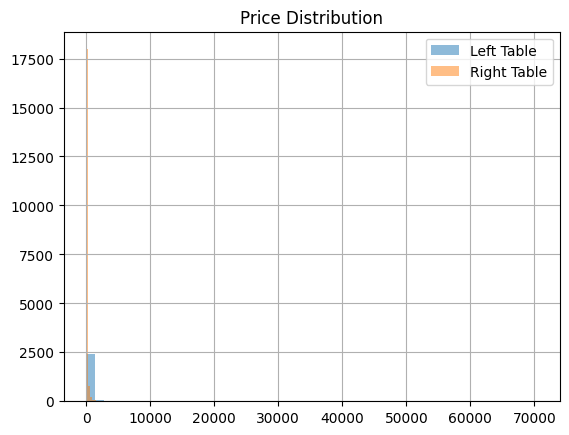

In [7]:
# Histogram of prices if price data is available
ltable['price'].hist(bins=50, alpha=0.5, label='Left Table')
rtable['price'].hist(bins=50, alpha=0.5, label='Right Table')
plt.legend()
plt.title('Price Distribution')
plt.show()

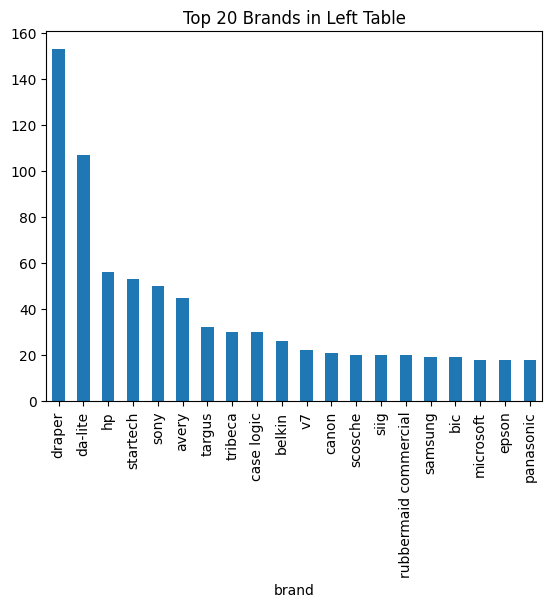

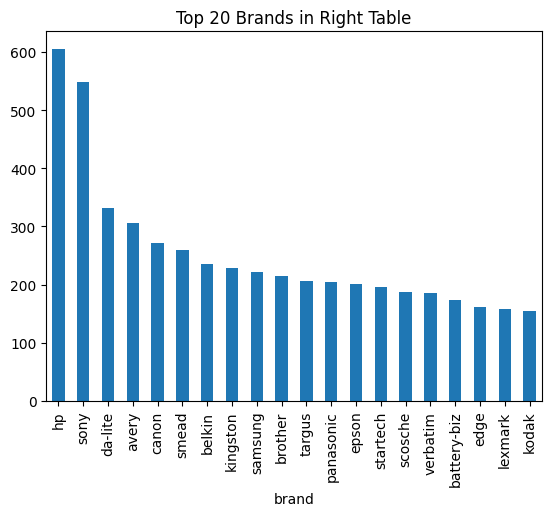

In [8]:
# Count of products per brand for both tables
ltable['brand'].value_counts().head(20).plot(kind='bar', title='Top 20 Brands in Left Table')
plt.show()

rtable['brand'].value_counts().head(20).plot(kind='bar', title='Top 20 Brands in Right Table')
plt.show()

In [9]:
# Fill missing values and normalize text
def preprocess_data(df):
    df.fillna({'brand': '', 'modelno': '', 'category': ''}, inplace=True)
    df['title'] = df['title'].str.lower().str.replace(r'\W', '')
    return df

In [10]:
ltable = preprocess_data(ltable)
rtable = preprocess_data(rtable)

# Step 2: Feature Engineering
We need to create features that capture the similarity between product records in the two tables.

In [11]:
# Function to train Word2Vec model on our corpus of titles
def train_word2vec(ltable, rtable):
    # Combine all titles from both tables into one large list
    all_titles = ltable['title'].tolist() + rtable['title'].tolist()
    sentences = [title.split() for title in all_titles]
    # Train a Word2Vec model
    model = gensim.models.Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)
    return model

# Train Word2Vec on the entire dataset
word2vec_model = train_word2vec(ltable, rtable)

# Function to vectorize titles using the Word2Vec model
def vectorize_title(title, model):
    vectors = [model.wv[word] for word in title.split() if word in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)

# Vectorize titles in both ltable and rtable
ltable['title_vec'] = ltable['title'].apply(lambda x: vectorize_title(x, word2vec_model))
rtable['title_vec'] = rtable['title'].apply(lambda x: vectorize_title(x, word2vec_model))

In [12]:
# Create interaction features
def create_interaction_features(df):
    df['brand_category_interaction'] = df['brand'] + "_" + df['category']
    return df

ltable = create_interaction_features(ltable)
rtable = create_interaction_features(rtable)

In [13]:
def enrich_features(df):
    df['title_length'] = df['title'].apply(lambda x: len(x.split()))
    df['has_numbers'] = df['title'].str.contains(r'\d').astype(int)
    return df

ltable = enrich_features(ltable)
rtable = enrich_features(rtable)

In [14]:
def create_final_features(df, ltable, rtable):
    # Merging and explicitly checking the columns
    df = df.merge(ltable, left_on='ltable_id', right_on='ltable_id', suffixes=('', '_l'))
    df = df.merge(rtable, left_on='rtable_id', right_on='rtable_id', suffixes=('', '_r'))
    
    print("Columns after merging:", df.columns)  # Debug statement to check column names

    # Calculate cosine similarity from Word2Vec vectors
    df['cosine_similarity_w2v'] = df.apply(lambda x: np.dot(x['title_vec'], x['title_vec_r']) /
                                           (np.linalg.norm(x['title_vec']) * np.linalg.norm(x['title_vec_r']) + 1e-10), axis=1)
    
    # Jaccard Similarity for title
    def jaccard_similarity(list1, list2):
        intersection = len(set(list1).intersection(list2))
        union = len(set(list1).union(list2))
        return intersection / union if union != 0 else 0
    
    df['title_jaccard'] = df.apply(lambda x: jaccard_similarity(x['title'].split(), x['title_r'].split()), axis=1)

    # Equal checks for brand, modelno, and category
    df['brand_equal'] = (df['brand'] == df['brand_r']).astype(int)
    df['modelno_equal'] = (df['modelno'] == df['modelno_r']).astype(int)
    df['category_equal'] = (df['category'] == df['category_r']).astype(int)
    
    return df

# Usage
train_data = create_final_features(train, ltable, rtable)
test_data = create_final_features(test, ltable, rtable)

# Now select the features to be used in training
features = [
    'cosine_similarity_w2v', 'title_jaccard', 'brand_equal', 'modelno_equal', 'category_equal',
    'title_length', 'has_numbers']

# Verify features exist in the DataFrame
print(train_data.columns)

Columns after merging: Index(['ltable_id', 'rtable_id', 'label', 'id', 'title', 'category', 'brand',
       'modelno', 'price', 'title_vec', 'brand_category_interaction',
       'title_length', 'has_numbers', 'title_r', 'category_r', 'brand_r',
       'modelno_r', 'price_r', 'title_vec_r', 'brand_category_interaction_r',
       'title_length_r', 'has_numbers_r'],
      dtype='object')
Columns after merging: Index(['Unnamed: 0', 'ltable_id', 'rtable_id', 'id', 'title', 'category',
       'brand', 'modelno', 'price', 'title_vec', 'brand_category_interaction',
       'title_length', 'has_numbers', 'title_r', 'category_r', 'brand_r',
       'modelno_r', 'price_r', 'title_vec_r', 'brand_category_interaction_r',
       'title_length_r', 'has_numbers_r'],
      dtype='object')
Index(['ltable_id', 'rtable_id', 'label', 'id', 'title', 'category', 'brand',
       'modelno', 'price', 'title_vec', 'brand_category_interaction',
       'title_length', 'has_numbers', 'title_r', 'category_r', 'brand_r

In [15]:
# Balance dataset using SMOTE
X, y = train_data[features], train_data['label']
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)

# Step 3: Model Training
We'll use a Random Forest classifier as it generally performs well for binary classification tasks like this.

In [16]:
# Define classifier parameter grids
param_grids = {
    'RandomForest': {
        'classifier': RandomForestClassifier(random_state=42),
        'params': {'n_estimators': [100, 300, 500], 'max_depth': [None, 10, 20], 'min_samples_split': [2, 5, 10]}
    },
    'GradientBoosting': {
        'classifier': GradientBoostingClassifier(random_state=42),
        'params': {'n_estimators': [100, 200], 'learning_rate': [0.1, 0.05], 'max_depth': [3, 7]}
    },
    'DecisionTree': {
        'classifier': DecisionTreeClassifier(random_state=42),
        'params': {'max_depth': [None, 10, 20], 'min_samples_split': [2, 5, 10]}
    },
    'KNeighbors': {
        'classifier': KNeighborsClassifier(),
        'params': {'n_neighbors': [3, 5, 7]}
    }
}

# Split data for training and validation
X_train, X_val, y_train, y_val = train_test_split(X_smote, y_smote, test_size=0.2, random_state=42)

In [17]:
best_models = {}
for name, spec in param_grids.items():
    print(f"Starting grid search for {name}.")
    grid_search = GridSearchCV(spec['classifier'], spec['params'], cv=10, scoring='f1', verbose=1)
    grid_search.fit(X_train, y_train)
    best_models[name] = grid_search.best_estimator_
    print(f"Best parameters for {name}: {grid_search.best_params_}")

Starting grid search for RandomForest.
Fitting 10 folds for each of 27 candidates, totalling 270 fits
Best parameters for RandomForest: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 500}
Starting grid search for GradientBoosting.
Fitting 10 folds for each of 8 candidates, totalling 80 fits
Best parameters for GradientBoosting: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200}
Starting grid search for DecisionTree.
Fitting 10 folds for each of 9 candidates, totalling 90 fits
Best parameters for DecisionTree: {'max_depth': None, 'min_samples_split': 2}
Starting grid search for KNeighbors.
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Best parameters for KNeighbors: {'n_neighbors': 3}


In [18]:
model_scores = {}
for name, model in best_models.items():
    scores = cross_val_score(model, X_smote, y_smote, cv=10, scoring='f1')
    model_scores[name] = np.mean(scores)
    print(f"{name} - Average F1 Score: {np.mean(scores):.3f} (+/- {np.std(scores) * 2:.3f})")

RandomForest - Average F1 Score: 0.918 (+/- 0.022)
GradientBoosting - Average F1 Score: 0.942 (+/- 0.090)
DecisionTree - Average F1 Score: 0.898 (+/- 0.053)
KNeighbors - Average F1 Score: 0.891 (+/- 0.014)


In [19]:
stacking_clf = StackingClassifier(
    estimators=[(name, model) for name, model in best_models.items()],
    final_estimator=LogisticRegression(),
    cv=10, verbose=1
)
stacking_clf.fit(X_train, y_train)
stack_f1 = cross_val_score(stacking_clf, X_smote, y_smote, cv=10, scoring='f1').mean()
model_scores['Stacking'] = stack_f1
print(f"Stacking Classifier - F1 Score: {stack_f1:.3f}")

Stacking Classifier - F1 Score: 0.942


# Step 4: Submission Preparation
Prepare the data in the format required by the competition.

In [20]:
best_model_name = max(model_scores, key=model_scores.get)
best_model = best_models[best_model_name] if best_model_name in best_models else stacking_clf
print(f"Selected best model: {best_model_name} with F1 Score: {model_scores[best_model_name]:.3f}")

best_model.fit(X_smote, y_smote)
final_predictions = best_model.predict(test_data[features])
test_data['predictions'] = final_predictions
test_data[['id', 'predictions']].to_csv('./Submission/final_predictions.csv', index=False)

Selected best model: Stacking with F1 Score: 0.942
